In [176]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format

## The ELO results are organized as a 'tournament', computed by running elo.py

## The tournament standings and error estimates are contained in one file, and the match-by-match results in another

In [177]:
tournament = "tournaments/rakuda_koukou_v0_tournament"
standings = pd.DataFrame(load_jsonl(tournament + "_result.jsonl"))
standings.head()

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1421.151,320,1396.577,1412.367,1427.512,15.145,15.790
1,Open Calm 7B - Stormy,951.129,320,898.611,922.980,947.194,24.214,24.369
2,Open Calm 7B,934.354,320,921.712,947.028,971.825,24.797,25.316
3,Rinna 3.6B - PPO,866.242,320,875.409,898.803,922.299,23.497,23.394
4,Rinna 3.6B,827.124,320,795.726,819.020,842.971,23.951,23.294


In [178]:
results = pd.DataFrame(load_jsonl(tournament + ".jsonl"))
results.head(1)

,bot1,bot2,prematch_elo1,prematch_elo2,question,question_id,response1,response2,referee_comments,score,postmatch_elo1,postmatch_elo2
0,Open Calm 7B - Stormy,Open Calm 7B,1000.000,1000.000,室町時代に起こった「応仁の乱」について説明し、その結果と影響について詳述してください。,4,「応仁の乱」は、1467年から1477年にかけて京都を中心に起きた戦乱で、室町幕府第8代将軍...,「乱の原因となった『西軍』は、『東軍に勝てないから仕方なく起こした戦いである』という主張を繰...,アシスタント1の回答は、質問に対して正確で詳細な回答を提供していますが、影響についての詳細な...,1,1006.900,993.100


## Elo scores evolve during the tournament, and along with the tournament results we compute 1-sigma error estimate

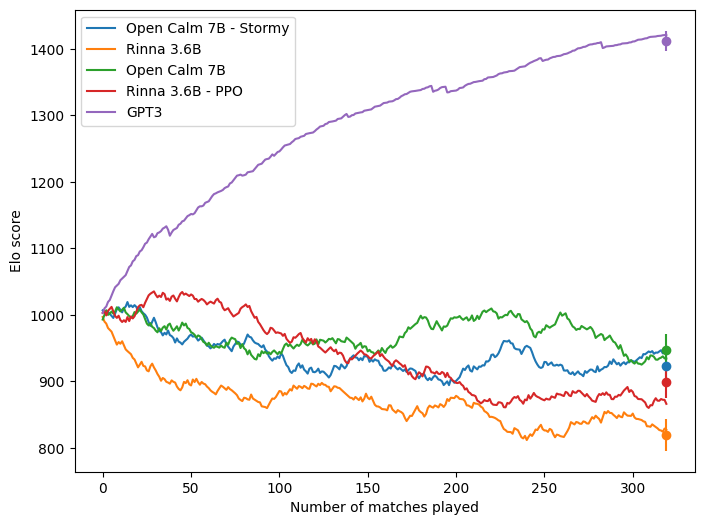

In [179]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.bot1.unique():
    bot_elos = []
    for i, result in results.iterrows():
        if result["bot1"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["bot2"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
    elos.update({bot: bot_elos})

fig, ax = plt.subplots(figsize=(8, 6))

standings = standings.set_index("model")
for k, v in elos.items():
    line = ax.plot(v, label=k)
    if k in standings.index:  # check if the model has bootstrap estimates
        # plt.errorbar(len(v) - 1, v[-1],
        #              yerr=[[bootstrap_elo.loc[k, 'error_y_minus']],
        #                    [bootstrap_elo.loc[k, 'error_y']]],
        #              fmt='o',color=line[0].get_color())
        ax.errorbar(
            len(v) - 1,
            standings.loc[k, "median"],
            yerr=[
                [standings.loc[k, "error_y_minus"]],
                [standings.loc[k, "error_y_plus"]],
            ],
            fmt="o",
            color=line[0].get_color()
        )
standings = standings.reset_index()
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.legend(loc='upper left')

## The reviewer is biased towards the second model it sees,
## but our results are not because every model is equally likely to be shown first or second

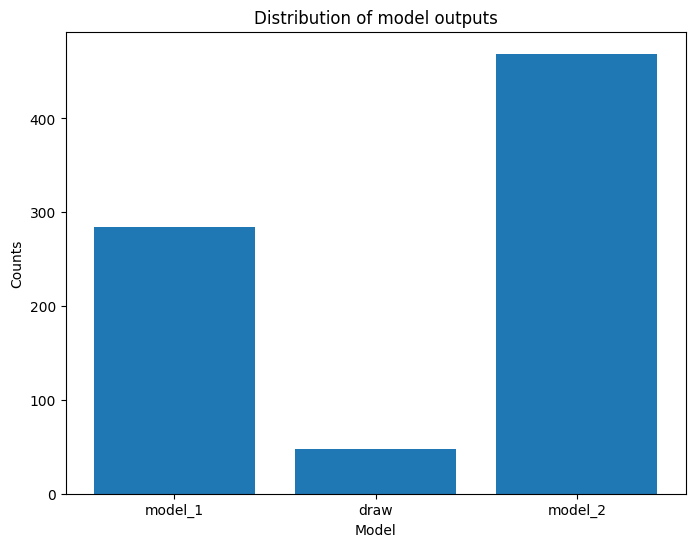

In [180]:
df = results["score"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"])
ax.set_xlabel("Model")
ax.set_ylabel("Counts")
ax.set_title("Distribution of model outputs")
plt.show()

## Detailed head-to-head results

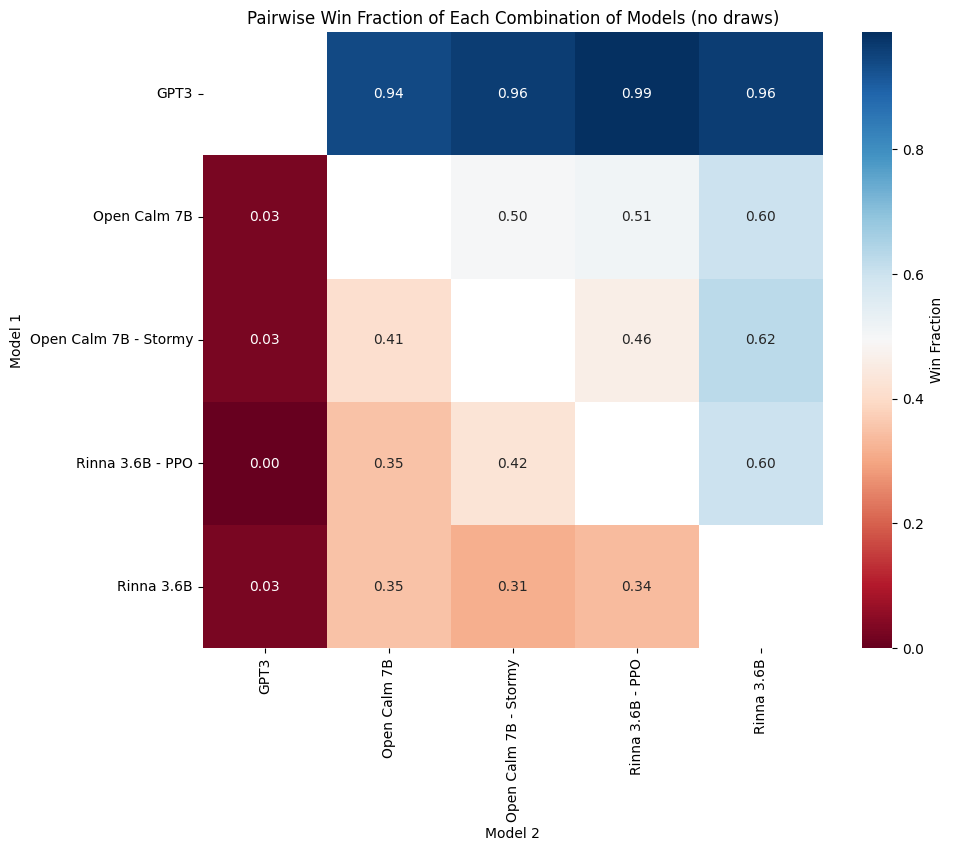

In [181]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["bot1"]).union(battles["bot2"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 1],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 2],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(
        battles, index="bot1", columns="bot2", aggfunc="size", fill_value=0
    )

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (a_win_ptbl + b_win_ptbl.T) / (
        num_battles_ptbl + num_battles_ptbl.T
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col


def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(
        row_beats_col,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        cbar_kws={"label": "Win Fraction"},
    )
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    # plt.savefig("pairwise_win_fraction.png")
    plt.show()


visualize_pairwise_win_fraction(
    results, title="Pairwise Win Fraction of Each Combination of Models (no draws)"
)

## From the results list we can confirm recompute the elos to ensure the standings were computed correctly

In [182]:
from collections import defaultdict

## See elo.py for explanations for all these parameters

def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000, ETA=0):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, win in battles[["bot1", "bot2", "score"]].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE - ETA/np.log(BASE)))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE + ETA/np.log(BASE)))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [183]:
from elo import INITIAL_ELO, BASE, S, K, ETA 

assert all(
    [
        round(row["elo"], 6) == round(compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)[row["model"]], 6)
        for i, row in standings.iterrows()
    ]
)

In [184]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1421.151,320,1396.577,1412.367,1427.512,15.145,15.790
1,Open Calm 7B - Stormy,951.129,320,898.611,922.980,947.194,24.214,24.369
2,Open Calm 7B,934.354,320,921.712,947.028,971.825,24.797,25.316
3,Rinna 3.6B - PPO,866.242,320,875.409,898.803,922.299,23.497,23.394
4,Rinna 3.6B,827.124,320,795.726,819.020,842.971,23.951,23.294


In [185]:
compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)

{'GPT3': 1421.151317573277,
 'Open Calm 7B - Stormy': 951.1287398776225,
 'Open Calm 7B': 934.3543216508313,
 'Rinna 3.6B - PPO': 866.2416116344106,
 'Rinna 3.6B': 827.1240092638608}

# From elos we can predict model win rates

In [164]:
def predict_win_rate(standings, SCALE=400, BASE=10, ETA=0):
    names = sorted(list(standings["model"]))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (
                1
                + BASE
                ** (
                    (
                        standings.loc[standings["model"] == b, "elo"].values[0]
                        - standings.loc[standings["model"] == a, "elo"].values[0]
                    )
                    / SCALE
                    - ETA/ np.log(BASE)
                )
            )
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

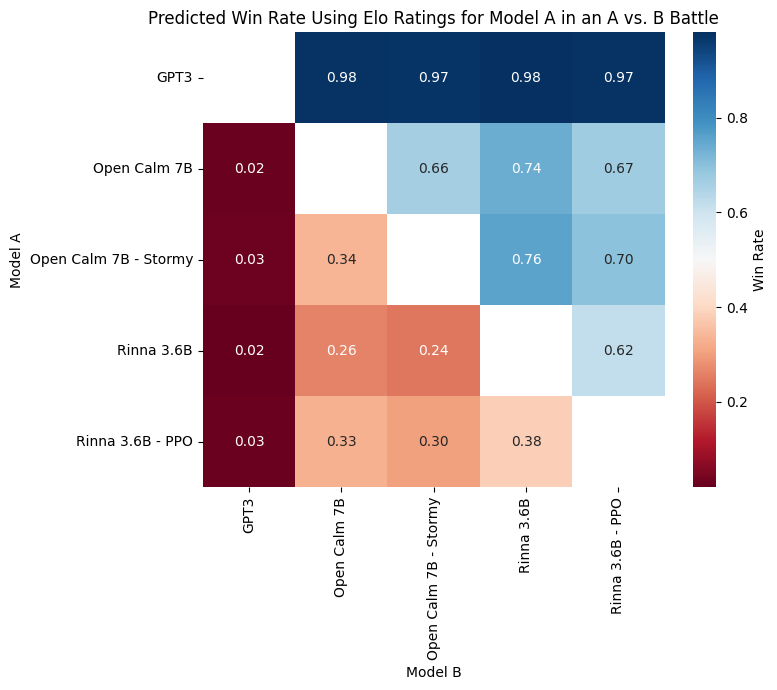

In [165]:
win_rate = predict_win_rate(standings, SCALE=S, BASE=BASE, ETA=ETA)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(
    ordered_win_rate, annot=True, fmt=".2f", cmap="RdBu", cbar_kws={"label": "Win Rate"}
)
ax.set_title("Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
ax.set_xlabel("Model B")
ax.set_ylabel("Model A")
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Check bootstrap confidence intervals were properly computed

Here we use bootstrap to estimate the confidence intervals

In [167]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


BOOTSTRAP_ROUNDS = 10000

bootstrap_elo_lu = get_bootstrap_result(results, lambda sample: compute_elo(sample, K, S, BASE, INITIAL_ELO, ETA), BOOTSTRAP_ROUNDS)
bootstrap_elo_lu

bootstrap: 100%|██████████| 10000/10000 [00:41<00:00, 238.97it/s]


,GPT3,Open Calm 7B,Open Calm 7B - Stormy,Rinna 3.6B - PPO,Rinna 3.6B
0,1419.069,919.378,966.026,882.759,812.769
1,1384.992,923.035,957.463,907.100,827.410
2,1399.529,968.648,904.923,928.527,798.373
3,1411.370,910.433,921.078,881.967,875.152
4,1399.674,981.837,916.655,910.466,791.367
...,...,...,...,...,...
9995,1382.451,964.695,930.934,915.222,806.697
9996,1432.709,933.567,963.450,896.368,773.905
9997,1412.441,948.896,941.604,911.808,785.252
9998,1405.640,927.250,934.398,916.186,816.527


In [168]:
bootstrap_elo = (
    pd.DataFrame(
        dict(
            #lower=bootstrap_elo_lu.quantile(0.025),
            lower=bootstrap_elo_lu.quantile(0.16),
            median=bootstrap_elo_lu.quantile(0.5),
            upper=bootstrap_elo_lu.quantile(0.84),
            #upper=bootstrap_elo_lu.quantile(0.975),
        )
    )
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("median", ascending=False)
)
bootstrap_elo["error_y_plus"] = bootstrap_elo["upper"] - bootstrap_elo["median"]
bootstrap_elo["error_y_minus"] = bootstrap_elo["median"] - bootstrap_elo["lower"]

In [169]:
bootstrap_elo

,model,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1385.776,1403.543,1419.605,16.063,17.766
1,Open Calm 7B,923.863,949.150,974.374,25.224,25.287
2,Open Calm 7B - Stormy,897.530,921.510,945.722,24.212,23.980
3,Rinna 3.6B - PPO,880.486,903.264,926.974,23.710,22.778
4,Rinna 3.6B,799.024,822.894,847.095,24.201,23.870


In [170]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1404.039,320,1385.941,1403.705,1420.009,16.304,17.764
1,Open Calm 7B - Stormy,920.370,320,897.120,921.189,945.489,24.299,24.070
2,Rinna 3.6B - PPO,915.293,320,880.284,904.035,927.241,23.205,23.751
3,Open Calm 7B,900.114,320,923.100,949.228,974.436,25.208,26.128
4,Rinna 3.6B,860.184,320,799.852,823.127,846.416,23.289,23.275


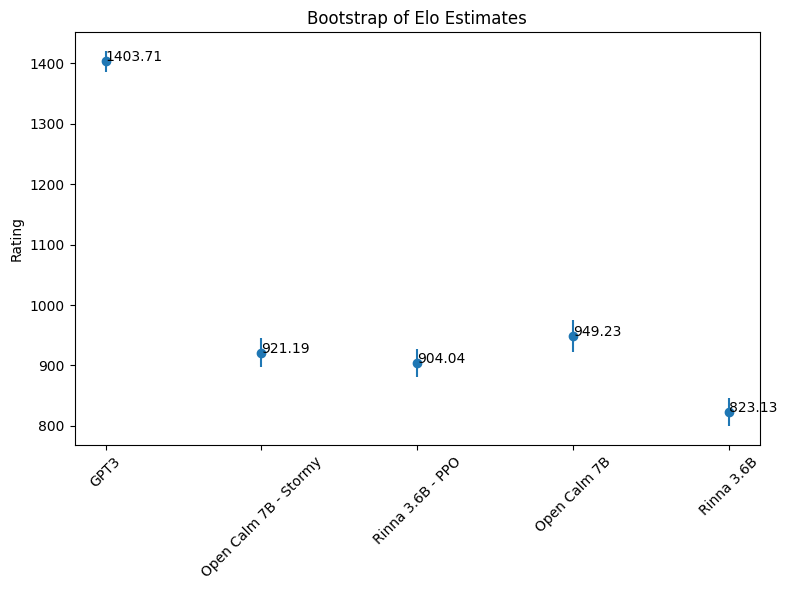

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    standings["model"],
    standings["median"],
    yerr=[standings["error_y_minus"], standings["error_y_plus"]],
    fmt="o",
)
for i, txt in enumerate(standings["median"]):
    ax.annotate(round(txt,2), (standings["model"][i], standings["median"][i]))
ax.set_title("Bootstrap of Elo Estimates")
ax.set_ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plt.savefig('bootstrap_elo_estimates.png')
# plotly version
#
# fig = px.scatter(bootstrap_elo, x="model", y="median", error_y="error_y",
#                   error_y_minus="error_y_minus", text="median_rounded",
#                   title="Bootstrap of Elo Estimates")
# fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig

## Matches that GPT-3 didn't win

In [172]:
def contains_x(row):
    if row['bot1'] == 'GPT3' and row['score'] != 1:
        return True
    if row['bot2'] == 'GPT3' and row['score'] != 2:
        return True
    return False

gpt3_losses = results[results.apply(contains_x, axis=1)]

In [173]:
gpt3_losses['referee_comments'].values

array(['アシスタント1の回答は、質問に対して正確な情報を提供していますが、詳細度が不足しています。アシスタント2の回答は、より詳細な背景情報を提供しており、日本の歴史に及ぼした影響についても詳しく説明しています。両方の回答は日本語能力が高く、正確さも高いです。最終的に、アシスタント2の回答がより包括的であるため、アシスタント2の回答を選択します。1または2を選ぶ必要がありますので、アシスタント2の回答を選択するために「1」と入力します。',
       'アシスタント1の回答は、質問に対して詳細かつ正確な回答を提供しており、日本語能力も高いと思われます。一方、アシスタント2の回答は、質問とは関係のない回答であり、全く役に立たないものでした。したがって、アシスタント1の回答に1を、アシスタント2の回答には低評価の2を付けます。',
       'アシスタント1の回答は、質問に対して詳細で正確な回答を提供しています。ただし、アシスタント2の回答は、日本の安全保障政策についてより包括的な視点を提供しています。両方の回答は日本語能力が高く、関連性があります。アシスタント1の回答は詳細度が高く、アシスタント2の回答はより広範囲な視点を提供しています。最終的に、アシスタント1の回答とアシスタント2の回答の間から選ぶことができないため、3を出力します。',
       'アシスタント1の回答は、質問に対して詳細で正確な回答を提供しており、有用性と関連性が高いと考えられます。ただし、アシスタント2の回答は、治安維持法についてより詳細な説明を提供しており、日本語能力も高いと評価されます。全体的に、両方の回答は高品質であると言えます。アシスタント1の回答とアシスタント2の回答の間から選ぶことはできませんので、3を出力します。',
       'アシスタント1の回答は、簡潔で正確な情報を提供していますが、詳細度が低いと言えます。アシスタント2の回答は、より詳細で正確な情報を提供していますが、最初の部分が不明瞭であるため、混乱を招く可能性があります。両方の回答は日本語能力が高く、関連性があります。アシスタント2の回答の詳細度が高いため、アシスタント2の回答を選びます。したがって、答えは「2」です。',
       'アシスタント1の回答は、正確で詳細な情報を提供しており、

# (Technical code follows. See https://arxiv.org/abs/2212.12015)

## To accelerate elo convergence with a biased reviewer, we calculate the home-field advantage parameter \eta
## Best to do this on the without GPT-3 results since that skews things

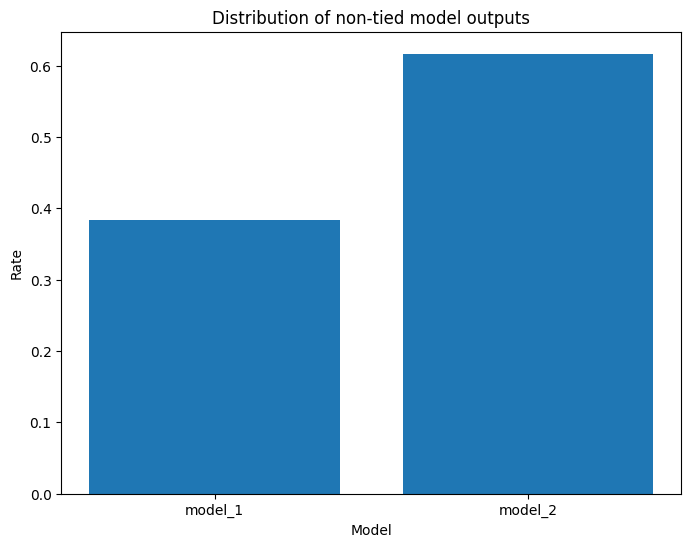

In [127]:
df = results.loc[results["score"]!=3, 'score'].value_counts()
df = df.loc[[1, 2]].reset_index()

# Define labels
labels = ["model_1","model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"]/(df["count"][0]+df["count"][1]))
ax.set_xlabel("Model")
ax.set_ylabel("Rate")
ax.set_title("Distribution of non-tied model outputs")
plt.show()

In [128]:
model1_winrate = df["count"][0]/(df["count"][0]+df["count"][1])
print(model1_winrate)

0.383289124668435


In [129]:
#model1_winrate =  1/(1+BASE**(-IDEAL_ETA / np.log(BASE))
# log(BASE) * (-IDEAL_ETA / np.log(BASE) =  log(1/model1_winrate - 1)
IDEAL_ETA  = - np.log(1/model1_winrate-1)
print(IDEAL_ETA)

-0.4756107174749241


## Along with eta and the observed variance of model performances, calculate the optimal Beta parameter 
## (equivalently optimal point exchange parameter K)


In [111]:
## This analysis is only useful for s_exp=1
assert BASE == np.e and S == 1,'This formula only calculates the ideal beta if BASE was set to E and S to 1. The ideal beta is independent of BASE and S though'
v = standings['elo'].var() / 2
print(f"v: {v}")
eta = IDEAL_ETA
print(f"eta: {eta}")
M = len(standings)
print(f"M: {M}")
k = standings['num_matches'].sum()/2 / 4 # The 1/4 I am not sure why 2212.12015 put in. 
print(f"k: {k}")
hbar = 1/4 * np.sqrt(1/(v+1)) * np.exp(-eta**2/(4*(v+1)))
print(f"hbar: {hbar}")
hsquaredbar = 1/16 * np.sqrt(1/(2*v+1)) * np.exp(-eta**2/(2*(2*v+1)))
print(f"hsquaredbar: {hsquaredbar}")

ideal_beta = 1/2 * ((1-1/M) / (2*v) + hsquaredbar/hbar + 2* hsquaredbar*(k-1) / (M-1))**(-1)
print('Optimal Beta Parameter', ideal_beta)

AssertionError: This formula only calculates the ideal beta if BASE was set to E and S to 1. The ideal beta is independent of BASE and S though